In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from scipy import interp
from scipy.sparse import hstack, csr_matrix

import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

# CTRL + SHIFT + P => Run Code 
import sys
print('Python', sys.version)
print(sklearn.__version__)

Python 3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]
0.20.3


### Results Collection

In [3]:
global ResultsCollection 
ResultsCollection = pd.DataFrame(columns=('Algorithm', 'FeatureSet', 'TestAcc', 'TestAUC'))

global testSize
testSize = 0.25

# Create Folder to save too

from datetime import datetime
import os

date = datetime.now().strftime("%Y%m%d-%H%M%S") + " 3 Basic\\"

global path
path = "D:\\0_MyFiles\\0_Libraries\\Documents\\Education\\University\\Year 3\\FYP_Git\\Results\\" + str(date)

import os
if not os.path.exists(path):
    os.makedirs(path)

# Feature Set List

In [4]:
# Switch for multiple feautre sets
def getFeatureSet(number):
    return {
        1 : ['followers_count', 'friends_count', 'statuses_count', 'favourites_count', 'listed_count', 'verified', 'bot'],
        2 : ['followers_count', 'friends_count', 'statuses_count', 'favourites_count', 'listed_count_binary', 'verified', 
             'name_binary','description_binary', 'screen_name_binary','bot'],
        3 : ['followers_count', 'friends_count', 'statuses_count', 'favourites_count', 'listed_count', 'verified', 
             'name_binary','description_binarySTEM', 'screen_name_binary','bot'],        
        99 : ['followers_count', 'friends_count', 'statuses_count', 'favourites_count', 'listed_count', 'verified', 
              'name', 'screen_name', 'description', 'bot'],
    }[number]

# Import Training Data

In [5]:
# Read training data from csv
training_data = pd.read_csv('training_data.csv')
t2 = pd.read_csv('genuine_accounts_users.csv')
t3 = pd.read_csv('fake_followers_users.csv')
training_data['description'].fillna(' ', inplace=True)

features = getFeatureSet(99)

t2['bot'] = 0
t3['bot'] = 1

t2 = t2[features]
t3 = t3[features]
training_data = training_data[features]

new_data = t2.append(t3, ignore_index=True)
training_data = new_data.append(training_data, ignore_index=True)

training_data = training_data.sample(frac=1).reset_index(drop=True)
training_data['description'].fillna(' ', inplace=True)
training_data['verified'].fillna('0', inplace=True)

# Feature Development

### Stemming applied to description

In [5]:
def getTextDesc(desc):
    try:
        if isinstance(desc, float):
            return ''
        return desc
    except Exception as error:
        return ''
    
training_data['description'] = training_data.apply(lambda row: getTextDesc(row['description']), axis=1)

def stemLine(sentence):
    stemmer = nltk.PorterStemmer()
    translator=sentence.translate(str.maketrans("","", string.punctuation))
    translator = translator.lower()
    tokens = word_tokenize(translator)
    final = [stemmer.stem(tagged_word) for tagged_word in tokens]
    return " ".join(final)

training_data['descriptionStemmed'] = training_data['description'].apply(lambda row: stemLine(row))

### Binary True/False Conditions

In [6]:
#Binary
name_keywords = r'bot|b0t|papers'
stemmedKeywords = r'bot|b0t|random|#botally|creat|thi|time|//|botal|pubm|made|im|gener|day|everi|paper|follow|tweet|word'
keywords = r'bot|b0t|papers|#botally|follow|every|made|//|random|day|daily|tweet|tweets|made'

training_data['name_binary'] = training_data.name.str.contains(keywords, case=False, na=False)
training_data['screen_name_binary'] = training_data.screen_name.str.contains(keywords, case=False, na=False)

training_data['description_binarySTEM'] = training_data.descriptionStemmed.str.contains(stemmedKeywords, case=False, na=False)

training_data['description_binary'] = training_data.description.str.contains(keywords, case=False, na=False)
#training_data['status_binary'] = training_data.status.str.contains(keywords, case=False, na=False)

training_data['listed_count_binary'] = (training_data.listed_count>20000)==False

# Global Classifier Functions

In [7]:
# Using Features create the test and traing X and Y
def initiateXY(features):
    # set X to all data fields and Y to bot field
    x = training_data[features].iloc[:, :-1] # x is all data
    y = training_data[features].iloc[:, -1] # y is bot bool
    return x, y

# Get accuracy of a classifer
def get_results(classifer, x, y):
    ypredict = classifer.predict(x) # Predict Y value for all of X
    acc = accuracy_score(y, ypredict) # Find accuracy of prediction with the results 'Y'
    return acc

# Calculate and print a classifiers accuracy
def testClassifer(classifier, x, y, printRoc, runName, feauteSet):
    predicted = cross_val_predict(classifier, x, y, cv=10)
    acc = metrics.accuracy_score(y, predicted)
    
    if printRoc == True:
        kf = KFold(n_splits=10)
                
        tprs = []
        base_fpr = np.linspace(0, 1, 101)
        plt.figure(figsize=(5, 5))
        
        for train_index, test_index in kf.split(x):
            X_train, X_test = x.iloc[train_index], x.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            model = classifier.fit(X_train, y_train)
            y_score = model.predict_proba(X_test)
            fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])

            plt.plot(fpr, tpr, 'b', alpha=0.15)
            tpr = interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            tprs.append(tpr)
            
        tprs = np.array(tprs)
        mean_tprs = tprs.mean(axis=0)
        std = tprs.std(axis=0)

        mean_tprs[-1] = 1.0
        mean_auc = auc(base_fpr, mean_tprs)
        
        tprs_upper = np.minimum(mean_tprs + std, 1)
        tprs_lower = mean_tprs - std
        
        plt.plot(base_fpr, mean_tprs, 'b', label=r'Mean ROC AUC = %0.2f' % (mean_auc))
        plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
        
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.axes().set_aspect('equal', 'datalim')
        plt.title(str(feauteSet) + " " + runName + " ROC Curve")
        plt.legend(loc = 'lower right')
        plt.savefig(path + str(feauteSet) + ' ' + runName + '.png')
        plt.show()
        
    print('Accuracy:  ', acc)
    print('AUC:  ', mean_auc)
    
    return acc, mean_auc

# Classifiers

### Naive Bayes

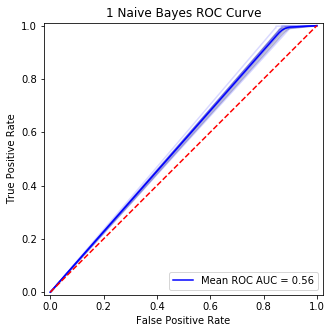

Accuracy:   0.5459363957597173
AUC:   0.5586774144306136


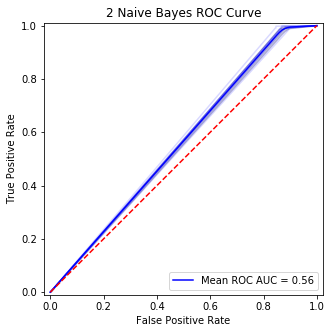

Accuracy:   0.5462481812512991
AUC:   0.5588562299113865


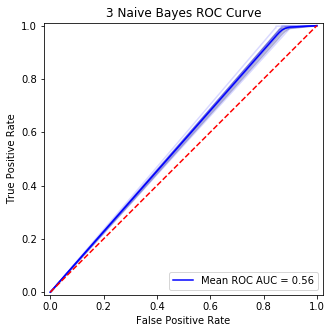

Accuracy:   0.5460403242569113
AUC:   0.5589608912723527


In [8]:
# Run Naive Bayes 
def run_NB(feauteSet, printRoc, runName):
    features = getFeatureSet(feauteSet)
    x, y = initiateXY(features)
    
    nb = MultinomialNB(alpha=0.00000000001)
    acc, mean_auc = testClassifer(nb, x, y, printRoc, runName, feauteSet)
    return pd.Series([runName, feauteSet, acc, mean_auc], 
                      index=['Algorithm','FeatureSet','TestAcc','TestAUC'])

ResultsCollection = ResultsCollection.append(run_NB(1, True, 'Naive Bayes'), ignore_index=True)
ResultsCollection = ResultsCollection.append(run_NB(2, True, 'Naive Bayes'), ignore_index=True)
ResultsCollection = ResultsCollection.append(run_NB(3, True, 'Naive Bayes'), ignore_index=True)

### Logistic Regression

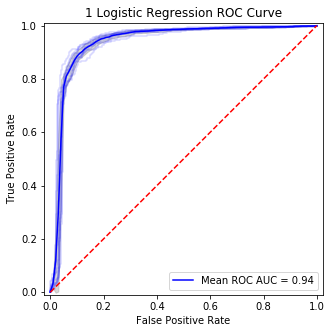

Accuracy:   0.8641654541675328
AUC:   0.9379802268301103


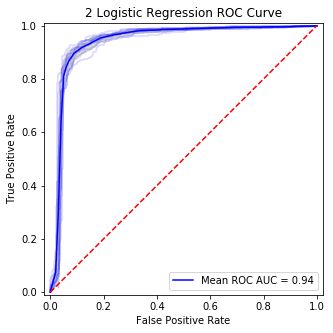

Accuracy:   0.8965911452920391
AUC:   0.9417639830818227


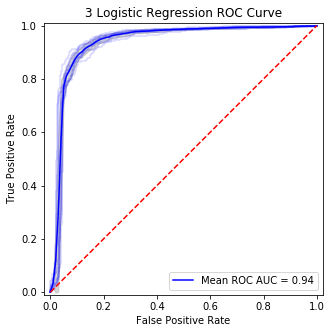

Accuracy:   0.8729993764290168
AUC:   0.9379824441250105


In [9]:
# Run Logistic Regression
def run_LR(feauteSet, printRoc, runName):
    features = getFeatureSet(feauteSet)
    x, y = initiateXY(features)

    lr = LogisticRegression(random_state=10, solver='lbfgs',multi_class='multinomial', C=0.00001)
    
    acc, mean_auc = testClassifer(lr, x, y, printRoc, runName, feauteSet)
    return pd.Series([runName, feauteSet, acc, mean_auc], 
                      index=['Algorithm','FeatureSet','TestAcc','TestAUC'])

ResultsCollection = ResultsCollection.append(run_LR(1, True, 'Logistic Regression'), ignore_index=True)
ResultsCollection = ResultsCollection.append(run_LR(2, True, 'Logistic Regression'), ignore_index=True)
ResultsCollection = ResultsCollection.append(run_LR(3, True, 'Logistic Regression'), ignore_index=True)

### Support Vector Machine

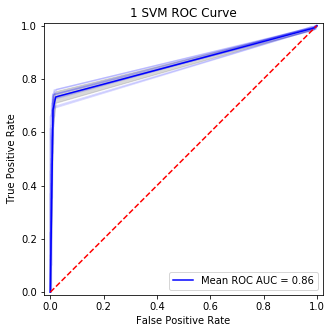

Accuracy:   0.7506755352317606
AUC:   0.856570666583534


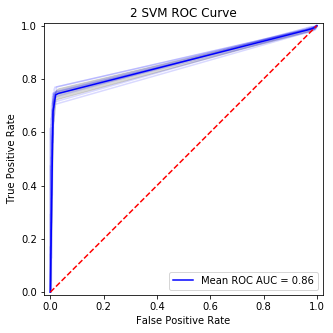

Accuracy:   0.7732280191228434
AUC:   0.8611304872000018


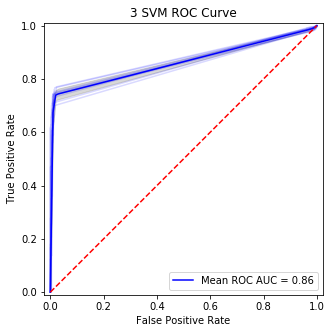

Accuracy:   0.7733319476200374
AUC:   0.8603115685231695


In [10]:
# Run Support Vector Machine 
def run_SVM(feauteSet, printRoc, runName):
    features = getFeatureSet(feauteSet)
    x, y = initiateXY(features)

    sv = svm.SVC(gamma='auto', probability=True, C=10)
    
    acc, mean_auc = testClassifer(sv, x, y, printRoc, runName, feauteSet)
    return pd.Series([runName, feauteSet, acc, mean_auc], 
                      index=['Algorithm','FeatureSet','TestAcc','TestAUC'])

ResultsCollection = ResultsCollection.append(run_SVM(1, True, 'SVM'), ignore_index=True)
ResultsCollection = ResultsCollection.append(run_SVM(2, True, 'SVM'), ignore_index=True)
ResultsCollection = ResultsCollection.append(run_SVM(3, True, 'SVM'), ignore_index=True)

### Decision Tree 

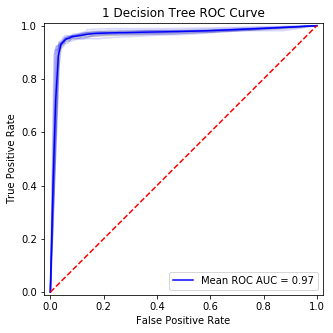

Accuracy:   0.9468925379339015
AUC:   0.9651480074038683


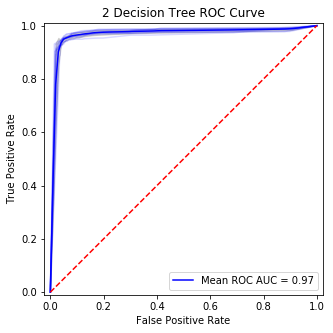

Accuracy:   0.9501143213469133
AUC:   0.9670808458652308


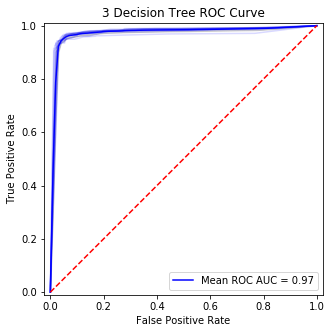

Accuracy:   0.9515693203076283
AUC:   0.9708982267216388


In [11]:
# Run Decision Tree
def run_DT(feauteSet, printRoc, runName):
    features = getFeatureSet(feauteSet)
    x, y = initiateXY(features)

    dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2, max_depth=10)

    acc, mean_auc = testClassifer(dt, x, y, printRoc, runName, feauteSet)
    return pd.Series([runName, feauteSet, acc, mean_auc], 
                      index=['Algorithm','FeatureSet','TestAcc','TestAUC'])

ResultsCollection = ResultsCollection.append(run_DT(1, True, 'Decision Tree'), ignore_index=True)
ResultsCollection = ResultsCollection.append(run_DT(2, True, 'Decision Tree'), ignore_index=True)
ResultsCollection = ResultsCollection.append(run_DT(3, True, 'Decision Tree'), ignore_index=True)    

### Random Forest

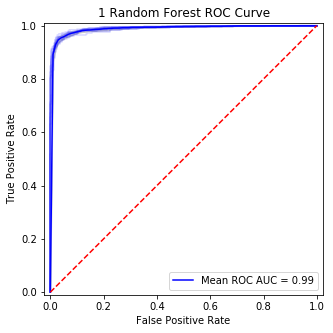

Accuracy:   0.9583246726252338
AUC:   0.9863627193943347


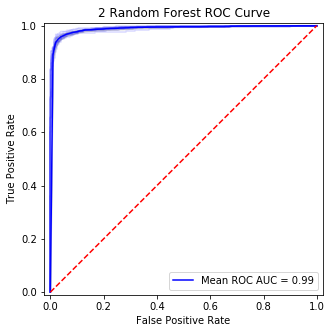

Accuracy:   0.961026813552276
AUC:   0.9863000338995646


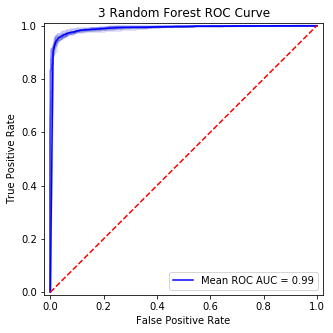

Accuracy:   0.9620660985242153
AUC:   0.9871510139118373


In [12]:
# Run Random Forest 
def run_RF(feauteSet, printRoc, runName):
    features = getFeatureSet(feauteSet)
    x, y = initiateXY(features)

    rf = RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=1, n_estimators=1000)

    acc, mean_auc = testClassifer(rf, x, y, printRoc, runName, feauteSet)
    return pd.Series([runName, feauteSet, acc, mean_auc], 
                      index=['Algorithm','FeatureSet','TestAcc','TestAUC'])

ResultsCollection = ResultsCollection.append(run_RF(1, True, 'Random Forest'), ignore_index=True)
ResultsCollection = ResultsCollection.append(run_RF(2, True, 'Random Forest'), ignore_index=True)
ResultsCollection = ResultsCollection.append(run_RF(3, True, 'Random Forest'), ignore_index=True)

# Ensemble Approaches

### Bagging

In [13]:
# Run Bagging DT
def run_bagging_DT(feauteSet, printRoc, runName):
    features = getFeatureSet(feauteSet)
    x, y = initiateXY(features)

    bagClf = BaggingClassifier(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2, max_depth=8),
                               n_estimators=500)

    
    acc, mean_auc = testClassifer(bagClf, x, y, printRoc, runName, feauteSet)
    return pd.Series([runName, feauteSet, acc, mean_auc], 
                      index=['Algorithm','FeatureSet','TestAcc','TestAUC'])

# Run Bagging RF
def run_bagging_RF(feauteSet, printRoc, runName):
    features = getFeatureSet(feauteSet)
    x, y = initiateXY(features)

    bagClf = BaggingClassifier(RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_leaf=1, n_estimators=1000),
                               n_estimators=500)
    
    acc, mean_auc = testClassifer(bagClf, x, y, printRoc, runName, feauteSet)
    return pd.Series([runName, feauteSet, acc, mean_auc], 
                      index=['Algorithm','FeatureSet','TestAcc','TestAUC'])

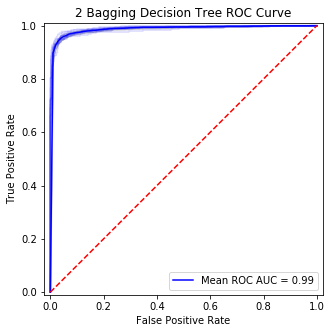

Accuracy:   0.9571814591561006
AUC:   0.9852145763129684


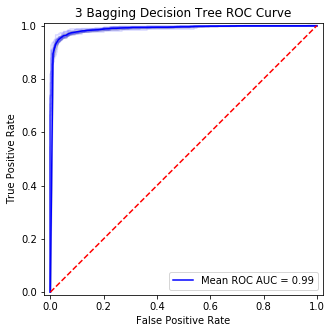

Accuracy:   0.9589482436083975
AUC:   0.9861647058733777


In [14]:
ResultsCollection = ResultsCollection.append(run_bagging_DT(2, True, 'Bagging Decision Tree'), ignore_index=True)
ResultsCollection = ResultsCollection.append(run_bagging_DT(3, True, 'Bagging Decision Tree'), ignore_index=True)

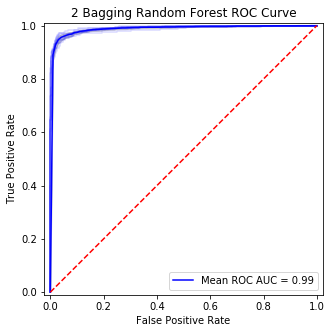

Accuracy:   0.9592600290999792
AUC:   0.9858615790678925


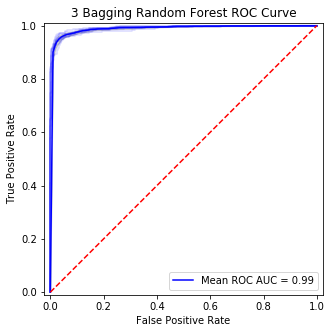

Accuracy:   0.9602993140719185
AUC:   0.9866554115567274


In [15]:
ResultsCollection = ResultsCollection.append(run_bagging_RF(2, True, 'Bagging Random Forest'), ignore_index=True)
ResultsCollection = ResultsCollection.append(run_bagging_RF(3, True, 'Bagging Random Forest'), ignore_index=True)

### Boosting

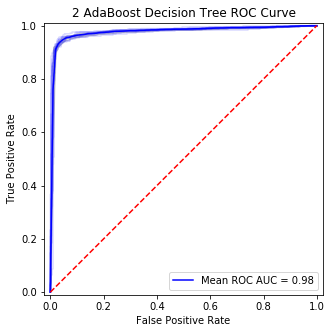

Accuracy:   0.9512575348160466
AUC:   0.9764966180164605


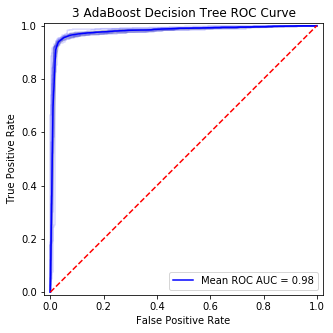

Accuracy:   0.9549989607150281
AUC:   0.9779478079506267


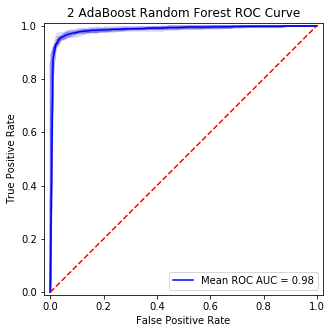

Accuracy:   0.9589482436083975
AUC:   0.9837577558990157


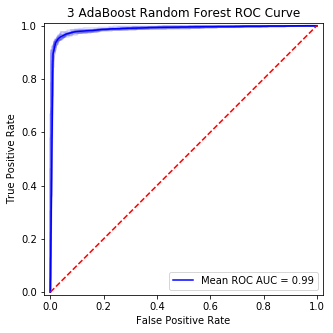

Accuracy:   0.9611307420494699
AUC:   0.9853170091822041


In [16]:
def run_ada_DT(feauteSet, printRoc, runName):
    features = getFeatureSet(feauteSet)
    x, y = initiateXY(features)
    
    bagClf = AdaBoostClassifier(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2, max_depth=10))

    acc, mean_auc = testClassifer(bagClf, x, y, printRoc, runName, feauteSet)
    return pd.Series([runName, feauteSet, acc, mean_auc], 
                      index=['Algorithm','FeatureSet','TestAcc','TestAUC'])

def run_ada_RF(feauteSet, printRoc, runName):
    features = getFeatureSet(feauteSet)
    x, y = initiateXY(features)
    
    bagClf = AdaBoostClassifier(RandomForestClassifier(criterion='entropy', 
                                                    max_depth=10, min_samples_leaf=1, n_estimators=1000))

    acc, mean_auc = testClassifer(bagClf, x, y, printRoc, runName, feauteSet)
    return pd.Series([runName, feauteSet, acc, mean_auc], 
                      index=['Algorithm','FeatureSet','TestAcc','TestAUC'])

ResultsCollection = ResultsCollection.append(run_ada_DT(2, True, 'AdaBoost Decision Tree'), ignore_index=True)   
ResultsCollection = ResultsCollection.append(run_ada_DT(3, True, 'AdaBoost Decision Tree'), ignore_index=True)  
ResultsCollection = ResultsCollection.append(run_ada_RF(2, True, 'AdaBoost Random Forest'), ignore_index=True)   
ResultsCollection = ResultsCollection.append(run_ada_RF(3, True, 'AdaBoost Random Forest'), ignore_index=True)   

### Gradient Boosting Classifier

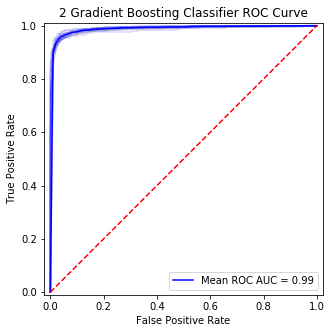

Accuracy:   0.9596757430887549
AUC:   0.9859954071143864


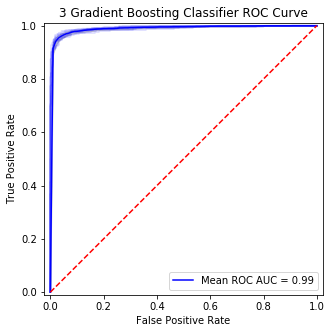

Accuracy:   0.9633132404905425
AUC:   0.9869513435470058


In [17]:
def run_grad(feauteSet, printRoc, runName):
    features = getFeatureSet(feauteSet)
    x, y = initiateXY(features)

    bagClf = GradientBoostingClassifier(learning_rate=0.03, max_depth=5, min_samples_leaf=40, n_estimators=500)

    acc, mean_auc = testClassifer(bagClf, x, y, printRoc, runName, feauteSet)
    return pd.Series([runName, feauteSet, acc, mean_auc], 
                      index=['Algorithm','FeatureSet','TestAcc','TestAUC'])

ResultsCollection = ResultsCollection.append(run_grad(2, True, 'Gradient Boosting Classifier'), ignore_index=True)   
ResultsCollection = ResultsCollection.append(run_grad(3, True, 'Gradient Boosting Classifier'), ignore_index=True)   

### Voting

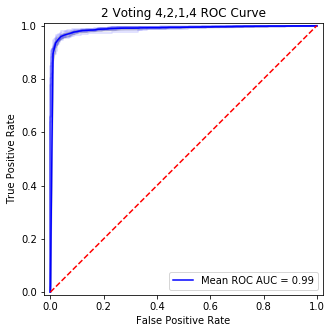

Accuracy:   0.960922885055082
AUC:   0.9851373832193964


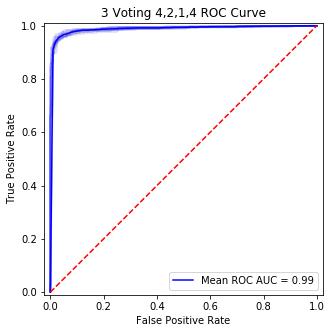

Accuracy:   0.962585741010185
AUC:   0.985505491658354


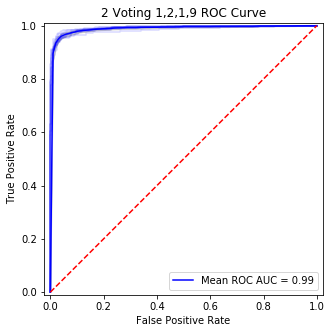

Accuracy:   0.9598836000831428
AUC:   0.9862017657567205


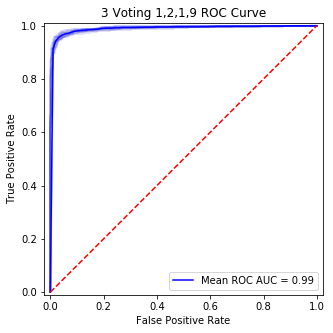

Accuracy:   0.9639368114737061
AUC:   0.9868404068951777


In [18]:
def run_voting(feauteSet, printRoc, runName, myWeight):
    features = getFeatureSet(feauteSet)
    x, y = initiateXY(features)

    dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2, max_depth=10)
    rf = RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=1, n_estimators=1000)
    lr = LogisticRegression(random_state=10, solver='lbfgs',multi_class='multinomial', C=0.00001)
    sv = svm.SVC(gamma='auto', probability=True)
    grd = GradientBoostingClassifier(learning_rate=0.03, max_depth=5, min_samples_leaf=40, n_estimators=500)

    voter = VotingClassifier(estimators=[('lr', lr), ('rf', rf), ('dt', dt), ('grd', grd)], voting='soft', weights=myWeight)

    acc, mean_auc = testClassifer(voter, x, y, printRoc, runName, feauteSet)
    return pd.Series([runName, feauteSet, acc, mean_auc], 
                      index=['Algorithm','FeatureSet','TestAcc','TestAUC'])

ResultsCollection = ResultsCollection.append(run_voting(2, True, 'Voting 4,2,1,4', [4,2,1,4]), ignore_index=True)   
ResultsCollection = ResultsCollection.append(run_voting(3, True, 'Voting 4,2,1,4', [4,2,1,4]), ignore_index=True)
ResultsCollection = ResultsCollection.append(run_voting(2, True, 'Voting 1,2,1,9', [1,2,1,9]), ignore_index=True)  
ResultsCollection = ResultsCollection.append(run_voting(3, True, 'Voting 1,2,1,9', [1,2,1,9]), ignore_index=True)  

In [19]:
print(ResultsCollection.sort_values('TestAcc'))

                       Algorithm FeatureSet   TestAcc   TestAUC
0                    Naive Bayes          1  0.545936  0.558677
2                    Naive Bayes          3  0.546040  0.558961
1                    Naive Bayes          2  0.546248  0.558856
6                            SVM          1  0.750676  0.856571
7                            SVM          2  0.773228  0.861130
8                            SVM          3  0.773332  0.860312
3            Logistic Regression          1  0.864165  0.937980
5            Logistic Regression          3  0.872999  0.937982
4            Logistic Regression          2  0.896591  0.941764
9                  Decision Tree          1  0.946893  0.965148
10                 Decision Tree          2  0.950114  0.967081
19        AdaBoost Decision Tree          2  0.951258  0.976497
11                 Decision Tree          3  0.951569  0.970898
20        AdaBoost Decision Tree          3  0.954999  0.977948
15         Bagging Decision Tree        

In [20]:
# Calculate and print a classifiers accuracy
def testClassiferVoting(classifier, xtrain, xtest, ytrain, ytest, printRoc, runName):
    acc_train = get_results(classifier, xtrain, ytrain)
    acc_test = get_results(classifier, xtest, ytest)
    
    if printRoc == True:
        plotROC(classifier, xtest, ytest, xtrain, ytrain, runName)
    
    return acc_test


def run_votingWeights(feauteSet, testsize, printRoc, runName):
    features = getFeatureSet(feauteSet)
    xtrain, xtest, ytrain, ytest = initiateXY(features, testsize)

    dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50, min_samples_split=10)
    rf = RandomForestClassifier(criterion='entropy', min_samples_leaf=100, min_samples_split=20, n_estimators=500)
    lr = LogisticRegression(random_state=10, solver='lbfgs', multi_class='multinomial')
    sv = svm.SVC(gamma='auto', probability=True)
    grd = GradientBoostingClassifier(learning_rate=0.02, max_depth=5, min_sample_leaf=30, n_estimators=500)

    acc = 0
    acc_test = 0
    AUC = 0
    i = 0
    for w1 in range(1,5):
        for w2 in range(1,10):
            for w3 in range(1,6):
                for w4 in range(5,10):
                    if len(set((w1,w2,w3,w4))) == 1: # skip if all weights are equal
                        continue

                    eclf = VotingClassifier(estimators=[('lr', lr), ('rf', rf), ('dt', dt), ('grd', grd)], 
                                            voting='soft', weights=[w1,w2,w3,w4])
                    eclf = eclf.fit(xtrain, ytrain)

                    accTemp = testClassiferVoting(eclf, xtrain, xtest, ytrain, ytest, printRoc, runName)
                    if accTemp > acc:
                        print("HIGH >",w1,w2,w3,w4)
                        print(accTemp)
                        acc = accTemp
                        
                        acc_test, AUC = testClassifer(eclf, xtrain, xtest, ytrain, ytest, True, runName, feauteSet)
                    
                    i += 1
                    
    return pd.Series([(runName + str(w1) + str(w2) + str(w3) + str(w4)), feauteSet, acc_test, AUC], 
                      index=['Algorithm','FeatureSet','TestAcc','TestAUC'])
    print("COMPLETE")
    
#ResultsCollection = ResultsCollection.append(run_votingWeights(3, testSize, False, 'Voting Weighted'), ignore_index=True)   

#HIGH > 1 7 1 6
#FS 3 : Voting w/ dt, rf, lr
#0.9157142857142857

#HIGH > 4 2 1 4
#FS 3 : Voting w/ dt, rf, lr
#0.9171428571428571

#HIGH > 1 2 1 9
#FS 3 : Voting w/ dt, rf, lr
#0.9142857142857143

In [21]:
print(ResultsCollection.sort_values('TestAcc'))

                       Algorithm FeatureSet   TestAcc   TestAUC
0                    Naive Bayes          1  0.545936  0.558677
2                    Naive Bayes          3  0.546040  0.558961
1                    Naive Bayes          2  0.546248  0.558856
6                            SVM          1  0.750676  0.856571
7                            SVM          2  0.773228  0.861130
8                            SVM          3  0.773332  0.860312
3            Logistic Regression          1  0.864165  0.937980
5            Logistic Regression          3  0.872999  0.937982
4            Logistic Regression          2  0.896591  0.941764
9                  Decision Tree          1  0.946893  0.965148
10                 Decision Tree          2  0.950114  0.967081
19        AdaBoost Decision Tree          2  0.951258  0.976497
11                 Decision Tree          3  0.951569  0.970898
20        AdaBoost Decision Tree          3  0.954999  0.977948
15         Bagging Decision Tree        

In [22]:
outPutFileName = path + 'Results.csv'
ResultsCollection.sort_values('TestAcc').to_csv(outPutFileName, encoding='utf-8')